#### Import Necessary dependencies

In [1]:

import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
ratio2 = 3
kernel_size = 3
lowThreshold = 30
address = './Data/S_03.jpg'

#### Import the image
#### Resize it 
& apply blur
GaussianBlur --> Because Sobel(/Canny) is too noisy --> Low-level Edge over everything

|--> to normalize the high frequency and low frequency values.

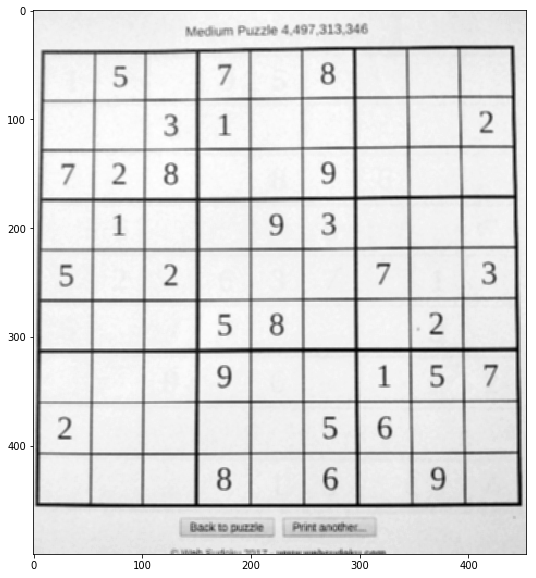

In [3]:
img = cv2.imread(address)
sudoku1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

r, c = sudoku1.shape
out_row = 500
sudoku1 = cv2.resize(sudoku1, (int(out_row * float(c)/r), out_row))

sudoku1 = cv2.blur(sudoku1, (3,3))
plt.figure(num = 0, figsize=(10, 10))
plt.imshow(sudoku1, cmap = 'gray')
plt.show()

# What does Canny do?
It thins all the edges to 1 pixel wide. What we really care is where are the edges and not the thickness of it.
We need to preserve only the dominant edges.

    1. For every pixel try to find if it the local maximum.

    2. Remove the edges that were local maximum, they are still not useful beacuse of a weak response(Noise).      Here Hysterises Thresholding comes into play.

## Hysterises Thresholding
Suppose we have a gradient image M. We know that pixel values above the threshold U would most likely be a part of an edge. We also know that values below a lower threshold L would have very extremely less probability of being a part of an edge.

what about pixels between L & U ?
We know that if a pixel is attached to an strong edge (i.e. greater than U) then it is highly probable to be an edge. Real edges have a tendency of seeming connected. 

Thus by hysteresis thresholding, weak edges would also be detected.
It preserves only the core image(shape of an object).
Also, for given thresholds, hysteresis thresholding better generalizes as compared to absolute one.

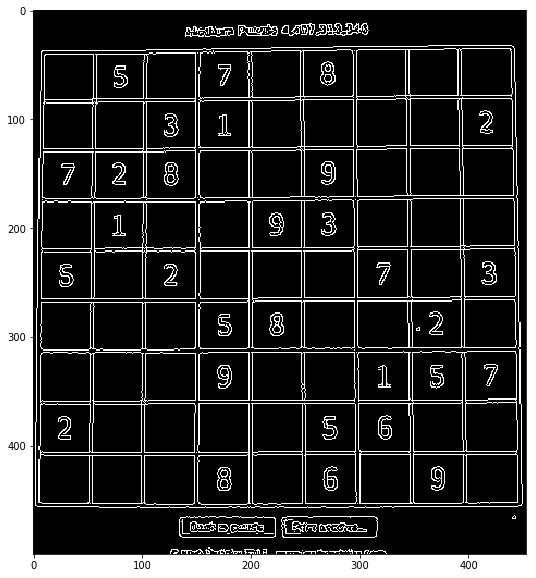

In [4]:
#Apply Canny detection
edges = cv2.Canny(sudoku1, lowThreshold, lowThreshold * ratio2, kernel_size)

plt.figure(num=0, figsize=(10, 10))
plt.imshow(edges, 'gray')
plt.show()

# Hough Line Transform
A line can be represented as  *ρ=xcosθ+ysinθ*  where ρ is the perpendicular distance from the origin to the line, and θ is the angle formed by this perpendicular line and horizontal axis. That direction varies on how you represent the coordinate system. This representation above is used in OpenCV. Any vertical line will have 0 degree and horizontal lines will have 90 degrees of θ. Normally, the origin point will be the top-left point in the image so the maximum θ is 90 degrees and minimum θ is 0 degree.

We know that every point on the line always satisfies this equation: *ρ = xcosθ + ysinθ*(1). If we know a pair (ρ,θ), we always can draw a line.

So, the idea of Hough Transform is creating a 2D array M as a matrix to hold the values of two parameters (ρ and θ). Let rows denote the ρρ and columns denote the θ. We assume there exists a line dd with ρ=ρ1 and θ=θ1 on the image. If a point A(x1,y1) lie on dd satisfies (1) ρ1=x1cosθ1+ y1sinθ1, we increase the value of M[ρ1][θ1] by 1. We continue this process for every point on the line, increasing the value of M[ρ1][θ1] by 1 if that point satisfies equation (1). At the end, the value of M[ρ1][θ1] will be must bigger than another cell in 2D array M. And the value of M[ρ1][θ1] will be also the length of the line.

The size of the 2D array depends on the accuracy you need. Suppose you want the accuracy of angles to be 1 degree, you need 180 columns. For ρ, the maximum distance possible is the diagonal length of the image. So taking one pixel accuracy, the number of rows can be the diagonal length of the image.

### Example

Suppose we have an image with 20x20 pixels and contain 2 lines like this.

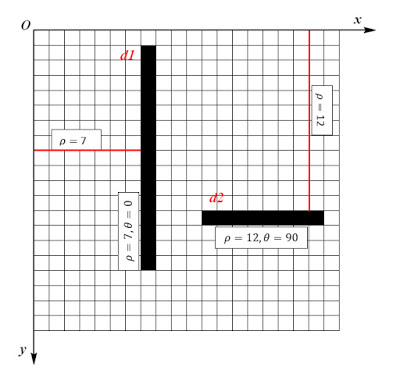

The perpendicular distance between d1 and the origin is ρ=7 and the angle between this perpendicular line and the horizontal axis (Ox) is 0 degrees and the length of  d1 is 15 (pixels). Similarly with d2, ρ=12, θ=90, and the length is 8 (pixels)

If you want the accuracy of angles to be 1 degree and the maximum distance possible is the diagonal length of the image, you will need a 2D array with 180 columns and 28 rows (20√2≈28).

After running Hough Line Transform on that image, we will have *M[7][0]=15* and *M[12][90]=8* corresponding to the length of d1 and d2.

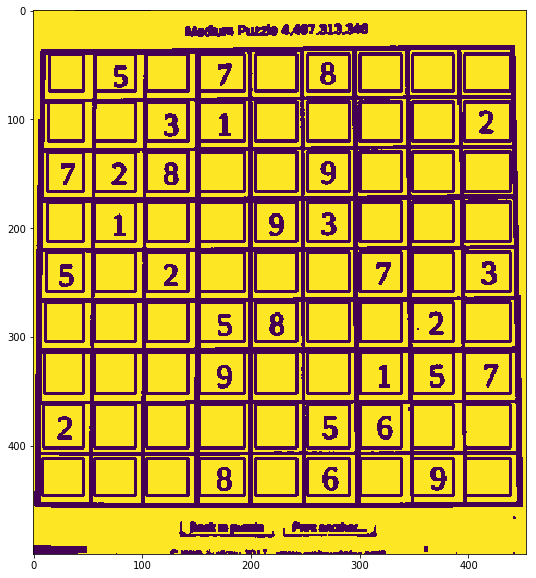

In [11]:
# Apply Hough Line Transform, return a list of rho and theta
lines = cv2.HoughLines(edges, 2, cv2.cv.CV_PI/180, 300, 0, 0)

if (lines is not None):
    lines = lines[0]
    lines = sorted(lines, key = lambda z: z[0])
    
    # Define the position of horizontal and vertical line
    pos_hori = 0
    pos_vert = 0
    
    # Create a list to store new bundle of lines
    New_lines = []
    # Store intersection points
    Points = []
    
    for rho, theta in lines:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        
        x1 = int(x0 + 1000*(-b))
        y1 = int(y0 + 1000*(a))
        
        x2 = int(x0 - 1000*(-b))
        y2 = int(y0 - 1000*(a))
        
        #If b > 0.5, the angle must be greater than 45. So, we consider it as a vertical line
        if (b > 0.5):
            #Check the position
            if(rho - pos_hori > 10):
                #Update the position
                pos_hori = rho
                # Saving new line, 0 is horizontal line, 1 is vertical line
                New_lines.append([rho, theta, 0])
        else:
            if(rho - pos_vert > 10):
                pos_vert = rho
                New_lines.append([rho, theta, 1])
    
    for i in range(len(New_lines)):
        if (New_lines[i][2] == 0):
            for j in range(len(New_lines)):
                if (New_lines[j][2] == 1):
                    theta1 = New_lines[i][1]
                    theta2 = New_lines[j][1]
                    
                    p1 = New_lines[i][0]
                    p2 = New_lines[j][0]
                    
                    xy = np.array([[np.cos(theta1), np.sin(theta1)],
                                   [np.cos(theta2), np.sin(theta2)]])
                    p = np.array([p1, p2])
                    
                    res = np.linalg.solve(xy, p)
                    
                    Points.append(res)
    # Sanity check                
    if (len(Points) == 100):
        sudoku1 = cv2.adaptiveThreshold(sudoku1, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV, 101, 1)
        
        for i in range(0, 9):
            for j in range(0, 9):
                # j+ i*10 will follow 0 1 2 3 4 5 6 7 8
                #                    10 11 12 13 14 15 16 17 18
                # 
                
                y1 = int(Points[j+i*10][1] + 5)
                # +11? We need opposite vertices to draw a rectangle
                y2 = int(Points[j+i*10 +11][1] - 5)
                
                x1 = int(Points[j+i*10][0] + 5)
                x2 = int(Points[j+i*10+11][0] - 5)
                
                
                cv2.rectangle(sudoku1, (x1, y1), (x2, y2), (0, 255, 0), 2)
    plt.figure(num = 0, figsize = (10, 10))
    plt.imshow(sudoku1)
    plt.show()
np.save('./Points.npy', Points)